In [1]:
import qsample as qs
import qiskit
import time
import stim
import numpy as np
import matplotlib.pyplot as plt
import time
import re
from tqdm.notebook import tqdm

import random

p=('1.00e-01',):   0%|          | 0/2000 [00:00<?, ?it/s]

0.8539268970489502


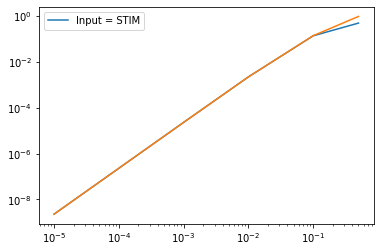

In [2]:
from Tests.circuit_test import Steane_test
Steane_test()

In [3]:
repetition = qs.Circuit(noisy=True).from_stim_circuit('''
X 0 1 2 3
    REPEAT 2 {
    H 0 2
    CNOT 0 3
    }
''')

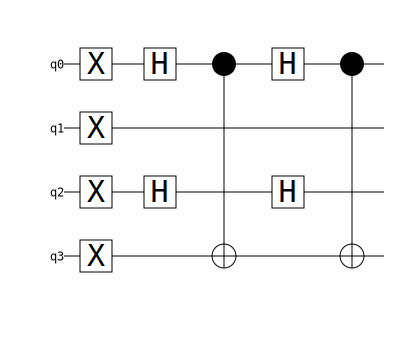

In [4]:
repetition.to_stim_circuit.diagram("timeline-svg")

# Input = STIM

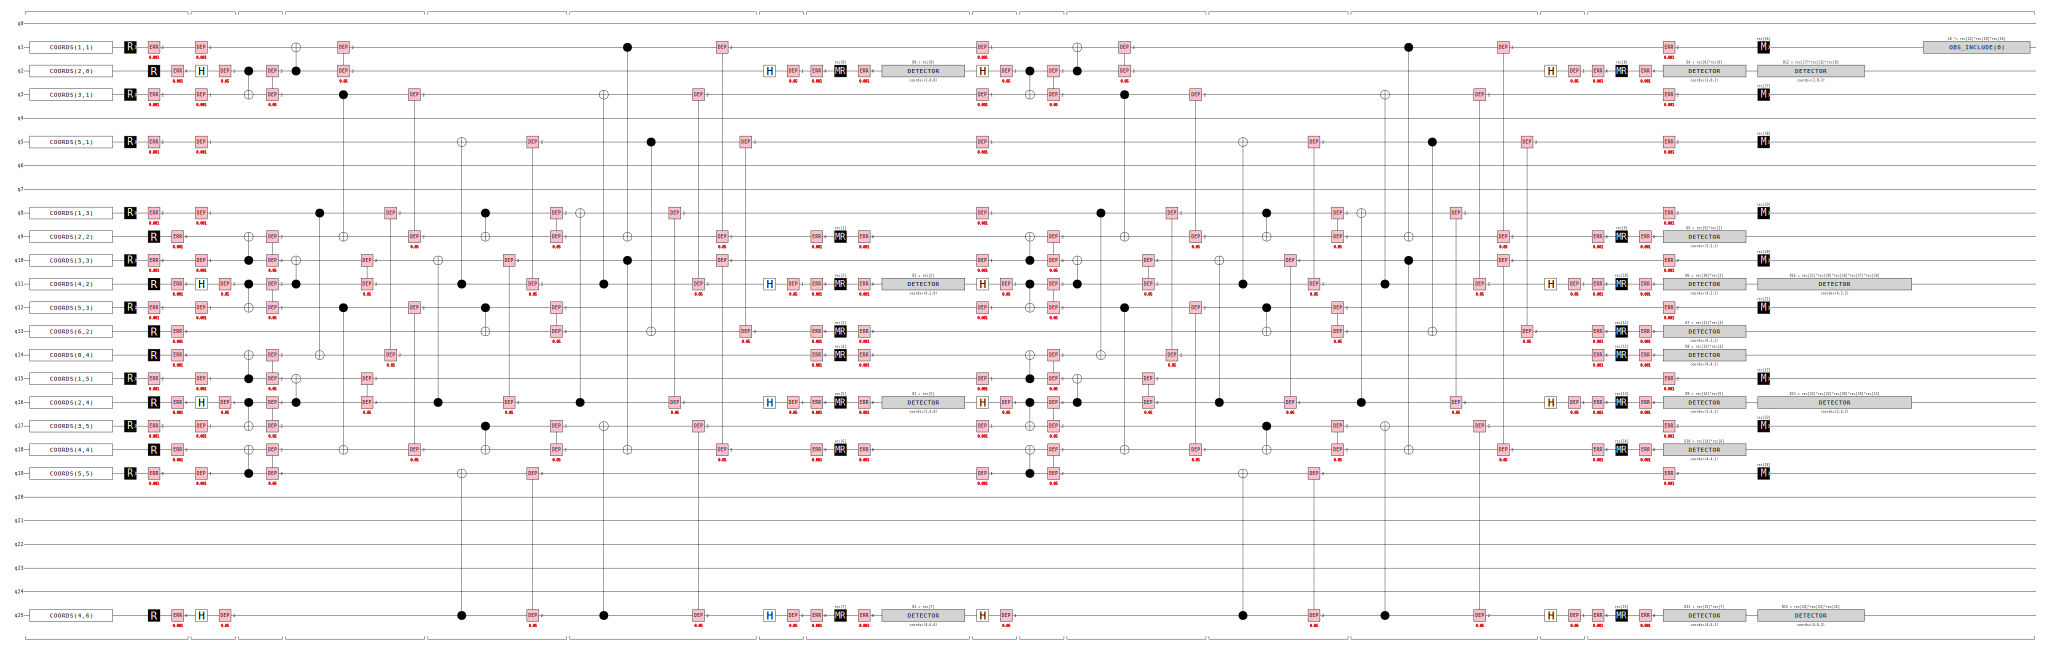

In [5]:
circuit = stim.Circuit.generated("surface_code:rotated_memory_x", rounds=2, distance=3,
    after_clifford_depolarization=0.05,
    after_reset_flip_probability=0.001,
    before_measure_flip_probability=0.001,
    before_round_data_depolarization=0.001,)
circuit.diagram("timeline-svg")

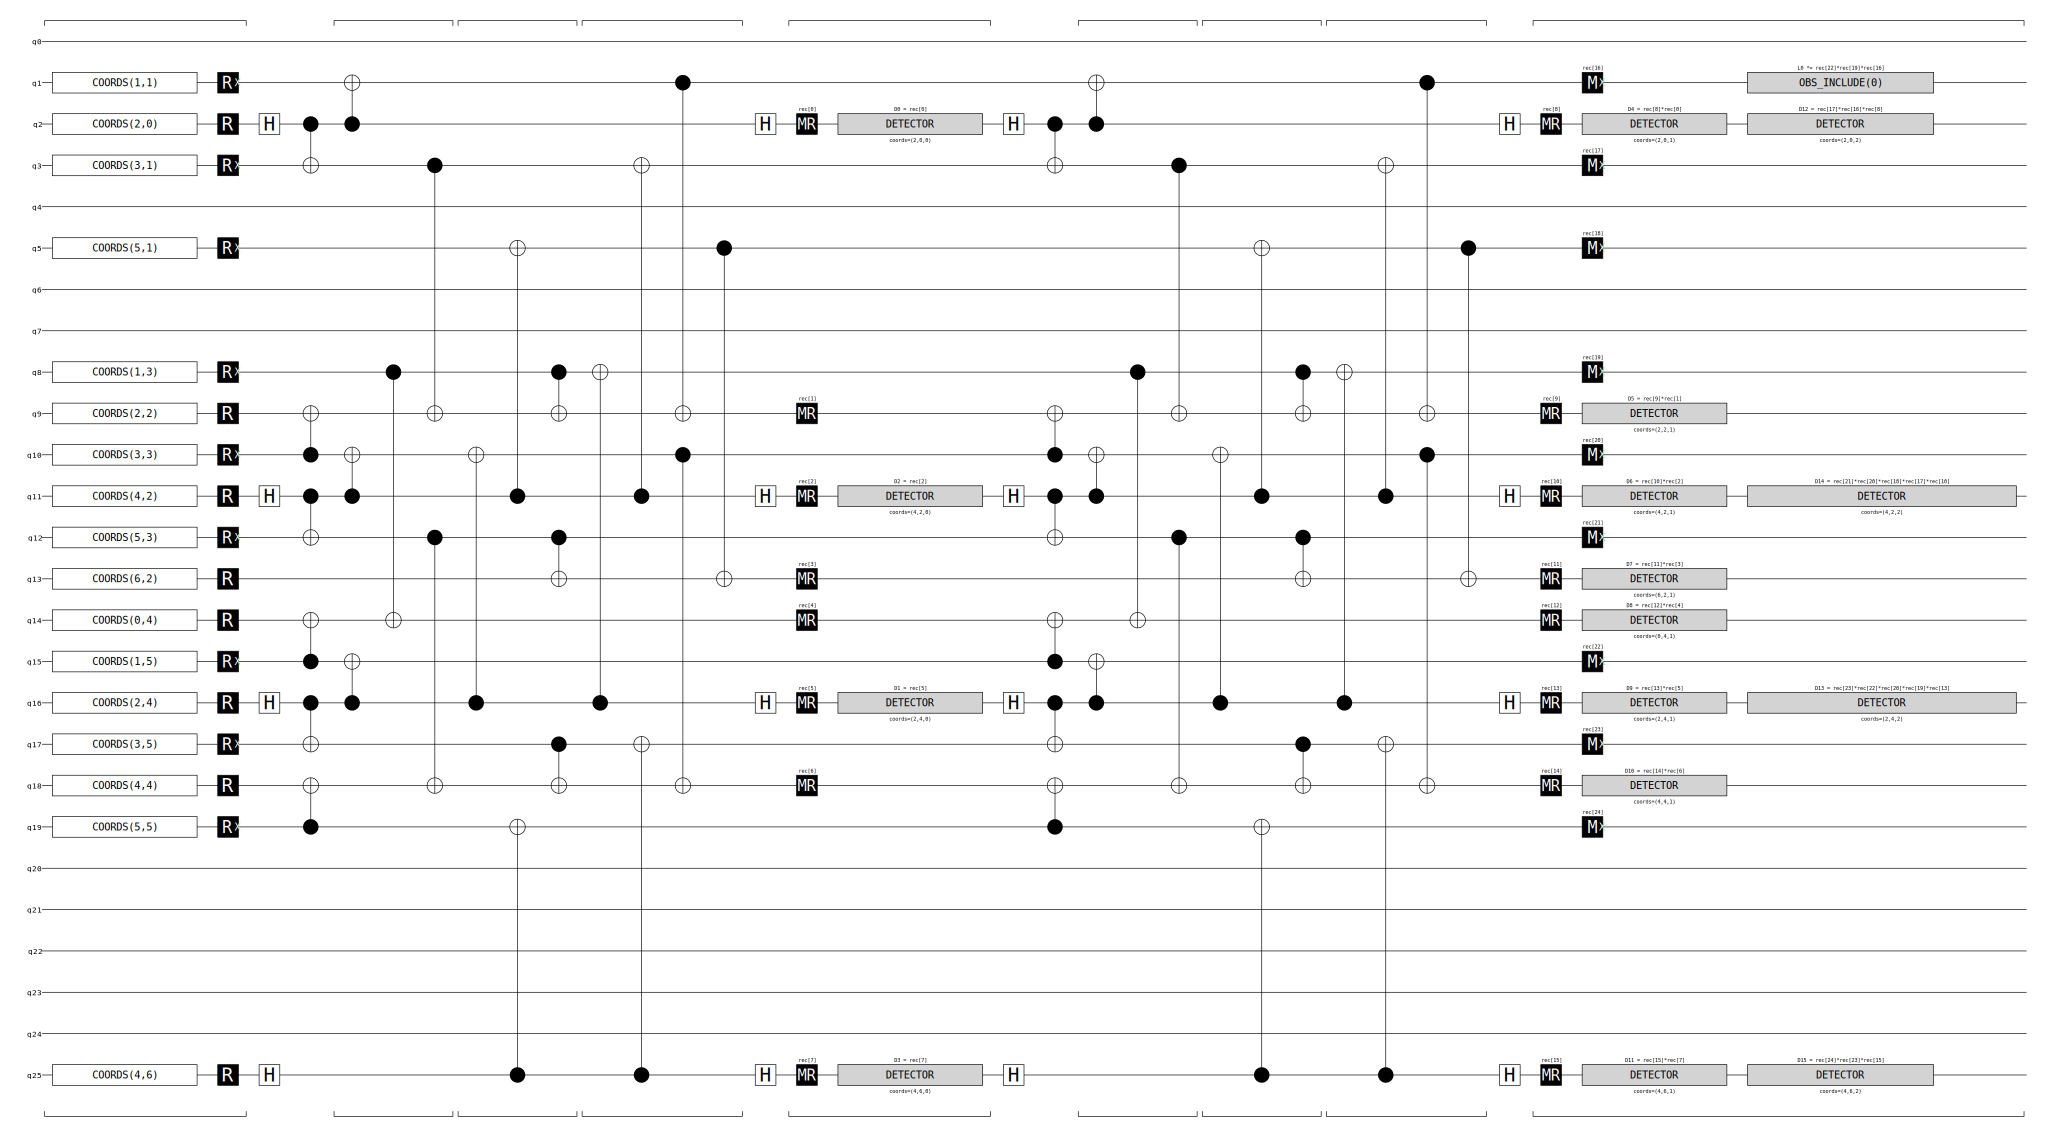

In [6]:
circuit = stim.Circuit.generated("surface_code:rotated_memory_x", rounds=2, distance=3)
circuit.diagram("timeline-svg")

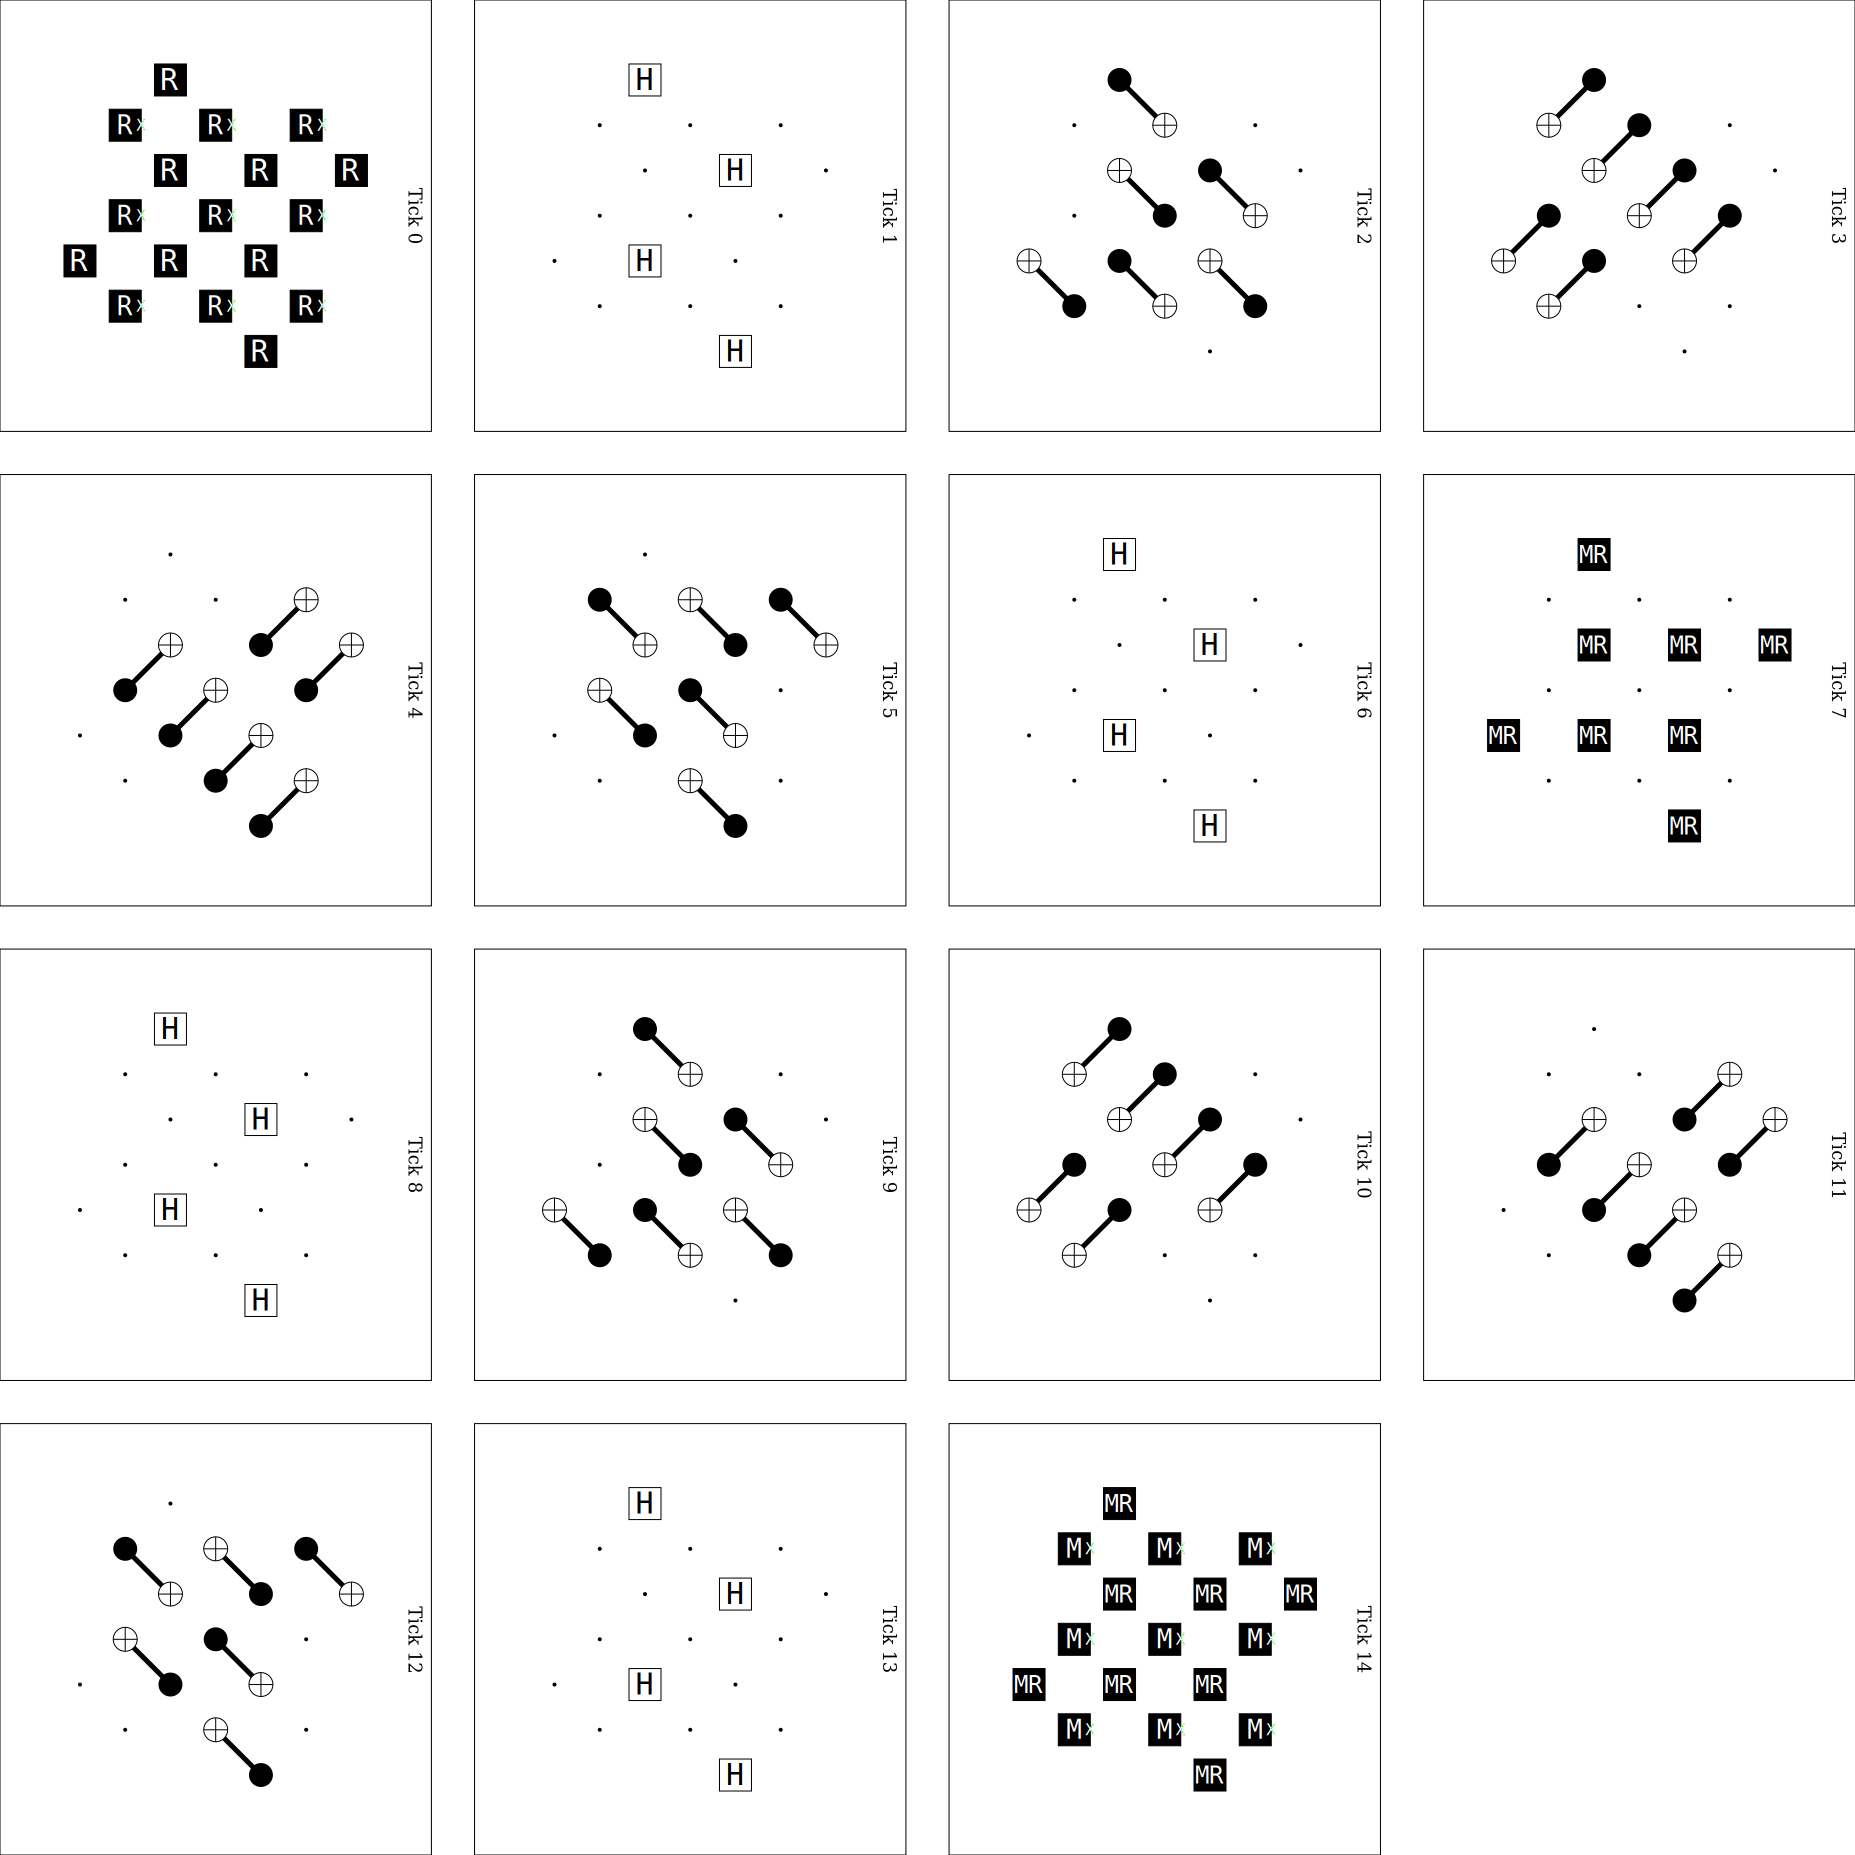

In [7]:
circuit.diagram("timeslice-svg")

In [8]:
surface_code = qs.Circuit(noisy=True)
surface_code.from_stim_circuit(circuit)

In [9]:
sampler = circuit.compile_detector_sampler()

In [10]:
num_shots = 10_000

sampler = circuit.compile_detector_sampler()
detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

print(
    f"Success rate after 1 QEC cycle: {(1 - (np.sum(observable_flips) / num_shots)) * 100} %"
)

Success rate after 1 QEC cycle: 100.0 %


In [11]:
dem = circuit.detector_error_model(decompose_errors=True)
import pymatching

matcher = pymatching.Matching.from_detector_error_model(dem)

In [12]:
print("Number of detectors:", matcher.num_detectors)
print("Number of nodes:", matcher.num_nodes)
print("Number of edges: ", matcher.num_edges)

Number of detectors: 16
Number of nodes: 16
Number of edges:  0


In [13]:
dem

stim.DetectorErrorModel('''
    detector(2, 0, 0) D0
    detector(2, 4, 0) D1
    detector(4, 2, 0) D2
    detector(4, 6, 0) D3
    shift_detectors(0, 0, 1) 0
    detector(2, 0, 0) D4
    detector(2, 2, 0) D5
    detector(4, 2, 0) D6
    detector(6, 2, 0) D7
    detector(0, 4, 0) D8
    detector(2, 4, 0) D9
    detector(4, 4, 0) D10
    detector(4, 6, 0) D11
    detector(2, 0, 1) D12
    detector(2, 4, 1) D13
    detector(4, 2, 1) D14
    detector(4, 6, 1) D15
    logical_observable L0
''')

In [14]:
matcher.decode_batch([[1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0]])

ValueError: No perfect matching could be found. This likely means that the syndrome has odd parity in the support of a connected component without a boundary.

In [ ]:
predictions = matcher.decode_batch(detection_events)
print(predictions)

In [15]:
num_errors = 0
for shot in range(num_shots):
    actual_for_shot = observable_flips[shot]
    predicted_for_shot = predictions[shot]
    if not np.array_equal(actual_for_shot, predicted_for_shot):
        num_errors += 1

print(f"Number of errors for {num_shots} shots: {num_errors}")

NameError: name 'predictions' is not defined

In [17]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(
        num_shots, separate_observables=True
    )

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

In [18]:
detection_events[1]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

--- Code distance: 3
Decoding errors at noise level 0.1: 1035
Decoding errors at noise level 0.2: 2972
Decoding errors at noise level 0.3: 4418
Decoding errors at noise level 0.4: 4934
Decoding errors at noise level 0.5: 5052
--- Code distance: 5
Decoding errors at noise level 0.1: 391
Decoding errors at noise level 0.2: 2179
Decoding errors at noise level 0.3: 4152
Decoding errors at noise level 0.4: 4845
Decoding errors at noise level 0.5: 4974
--- Code distance: 7
Decoding errors at noise level 0.1: 116
Decoding errors at noise level 0.2: 1396
Decoding errors at noise level 0.3: 3872
Decoding errors at noise level 0.4: 4960
Decoding errors at noise level 0.5: 4915


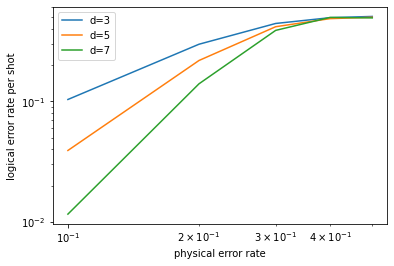

In [19]:
results = []
num_shots = 10_000
for d in [3, 5, 7]:
    print("--- Code distance:", d)
    xs = []
    ys = []
    for noise in [0.1, 0.2, 0.3, 0.4, 0.5]:
        circuit = stim.Circuit.generated(
            "repetition_code:memory",
            rounds=d * 3,
            distance=d,
            before_round_data_depolarization=noise,
        )
        num_errors_sampled = count_logical_errors(circuit, num_shots)
        print(f"Decoding errors at noise level {noise}: {num_errors_sampled}")
        xs.append(noise)
        ys.append(num_errors_sampled / num_shots)
    results.append((d, [xs, ys]))
    plt.plot(xs, ys, label="d=" + str(d))
plt.loglog()
plt.xlabel("physical error rate")
plt.ylabel("logical error rate per shot")
plt.legend()
plt.show()